# Random Forest RandomSearchCV
- Aggregated Invoice Data (Normalised consumption of each level and contract length) 
- Balanced Data - No Dummies

e.g. ["consommation_level_4"]
    ["consommation_level_1_norm"] = ["consommation_level_1"] / ["consommation_total"] / ["months_number"]

```


Model performance


```

In [1]:
# Used for filename when saving model
model_ref = "rf_rscv_agg_normcons_nodummies_balanced"

# Used for graph titles
model_name = "Random Forest RandomSearchCV"
model_details = "Aggregated Invoice Data (Normalised consumption) Balanced No-Dummies"


In [2]:
import pandas as pd
import numpy as np

import pyarrow
import fastparquet

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

#from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

In [3]:
# Reload model from file if needed

"""
saved_model_filename = ".skops"

unknown_types = get_untrusted_types(file=f"models/{saved_model_filename}")
# investigate the contents of unknown_types, and only load if you trust
# everything you see.
best_model = load(f"models/{saved_model_filename}", trusted=unknown_types)

"""

'\nsaved_model_filename = ".skops"\n\nunknown_types = get_untrusted_types(file=f"models/{saved_model_filename}")\n# investigate the contents of unknown_types, and only load if you trust\n# everything you see.\nbest_model = load(f"models/{saved_model_filename}", trusted=unknown_types)\n\n'

## Run data cleaning script, generate parquet files. 
Requires pyarrow and fastparquet (see requirements.txt)

In [4]:
# Open and run **ETL_export_parquet_invoice-level_+_client-level_mean.py**

## Import parquet files

In [5]:
"""# Import clean data 
# - Each row represents one invoice.
df_train_non_agg = pd.read_parquet("data/df_train_normcons_no_dummies_non_agg_norm.parquet")
df_final_test_non_agg = pd.read_parquet("data/df_final_test_normcons_no_dummies_non_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split
"""
# Import clean data
# - Each row represents one client. 
# - Invoices are summarised. 
# - The "consommation_level_x" columns show mean energy consumption per client.
df_train_agg = pd.read_parquet("data/df_train_normcons_no_dummies_agg.parquet")
df_final_test_agg = pd.read_parquet("data/df_final_test_normcons_no_dummies_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

In [6]:
# Choose dataset to use in this document
df = df_train_agg
df_final_test = df_final_test_agg

In [7]:
df.head()

,disrict,client_catg,region,creation_date,target,transactions_count,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1_norm,consommation_level_2_norm,consommation_level_3_norm,consommation_level_4_norm,counter_type_GAZ,counter_type_ELEC
0,60,11,101,34699,0,35,11,0,203,9,1.0,0.50,0.033550,0.000000,0.000000,False,True
1,69,11,107,37405,0,37,11,0,203,9,1.0,0.50,0.000000,0.000000,0.000000,False,True
2,62,11,301,31484,0,18,11,0,203,9,1.0,0.25,0.018440,0.000000,0.000000,False,True
3,69,11,105,35257,0,20,11,0,413,9,1.0,0.25,0.000000,0.000000,0.000000,False,True
4,62,11,303,41926,0,14,11,0,207,9,1.0,0.50,0.080451,0.093809,0.040092,False,True


In [8]:
df.describe()

,creation_date,target,transactions_count,counter_statue,reading_remarque,counter_coefficient,consommation_level_1_norm,consommation_level_2_norm,consommation_level_3_norm,consommation_level_4_norm
count,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,1.251230e+05,125123.000000,125123.000000,125123.000000
mean,37801.779602,0.059078,34.615531,0.010695,8.781734,1.001211,inf,0.072906,0.024651,0.023556
std,4107.568660,0.235772,25.782890,0.160331,0.726306,0.183005,NaN,0.119142,0.049995,0.099983
min,28161.000000,0.000000,1.000000,0.000000,6.000000,1.000000,1.013418e-03,0.000000,0.000000,0.000000
25%,34858.000000,0.000000,13.000000,0.000000,9.000000,1.000000,2.500000e-01,0.000000,0.000000,0.000000
50%,39018.500000,0.000000,31.500000,0.000000,9.000000,1.000000,5.000000e-01,0.042100,0.000000,0.000000
75%,41108.000000,0.000000,52.000000,0.000000,9.000000,1.000000,5.000000e-01,0.085616,0.031977,0.000000
max,43718.000000,1.000000,434.000000,5.000000,9.000000,40.000000,inf,0.996732,0.400000,0.995713


## Split Data to Train and Test

In [9]:
# Make sure final_test has same dummy columns in as training data (filled with False)
def add_missing_dummy_columns_and_fill_false(train, final_test): 

    cols_missing_from_final_test = (set(train) - set(final_test)) - set(['target'])

    for cols in cols_missing_from_final_test:   
        final_test[cols] = False
    print(f"Adding new cols to final_test: {cols_missing_from_final_test}")

add_missing_dummy_columns_and_fill_false(df, df_final_test)

Adding new cols to final_test: set()


In [10]:
X = df.loc[:, ~df.columns.isin(["target"])]
y = df["target"]
X_final_test = df_final_test

# make sure column order the same in X and X_final_test
X, X_final_test = X.align(X_final_test, join="right", axis=1)

RSEED = 42

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=RSEED
)


### Balance Classes

In [11]:

## Balance classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train,y_train)

## Imputing missing values

In [12]:
# % of missing values for each column in Training data
(100 * df.isnull().sum() / df.count()).sort_values(ascending=False)

consommation_level_4_norm    2.299337
consommation_level_3_norm    2.299337
consommation_level_2_norm    2.299337
consommation_level_1_norm    2.299337
disrict                      0.000000
reading_remarque             0.000000
counter_type_GAZ             0.000000
counter_coefficient          0.000000
counter_code                 0.000000
client_catg                  0.000000
counter_statue               0.000000
tarif_type                   0.000000
transactions_count           0.000000
target                       0.000000
creation_date                0.000000
region                       0.000000
counter_type_ELEC            0.000000
dtype: float64

In [13]:
# % of missing values for each column in the final test data. Compare with training data above to see if similar proportion.
(100 * df_final_test.isnull().sum() / df_final_test.count()).sort_values(ascending=False)

consommation_level_1_norm    2.218414
consommation_level_2_norm    2.218414
consommation_level_3_norm    2.218414
consommation_level_4_norm    2.218414
disrict                      0.000000
client_catg                  0.000000
region                       0.000000
creation_date                0.000000
transactions_count           0.000000
tarif_type                   0.000000
counter_statue               0.000000
counter_code                 0.000000
reading_remarque             0.000000
counter_coefficient          0.000000
counter_type_GAZ             0.000000
counter_type_ELEC            0.000000
dtype: float64

In [14]:
# What does the data look like for rows with missing data
df_missing_values = df[pd.isnull(df["consommation_level_1_norm"]) == True]

In [15]:
X_train_resampled

,disrict,client_catg,region,creation_date,transactions_count,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1_norm,consommation_level_2_norm,consommation_level_3_norm,consommation_level_4_norm,counter_type_GAZ,counter_type_ELEC
0,69,11,107,38240,22,11,0,207,9,1.0,0.25,0.000000,0.000000,0.000000,True,True
1,69,11,104,36136,26,11,0,413,9,1.0,0.50,0.000000,0.000000,0.000000,True,True
2,60,11,101,28458,30,11,0,410,8,1.0,0.25,0.101117,0.000000,0.000000,False,True
3,63,11,311,40522,4,11,0,203,8,1.0,0.25,0.028163,0.000000,0.000000,False,True
4,69,11,103,39233,63,11,0,207,9,1.0,0.25,0.000000,0.000000,0.000000,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168609,69,11,103,30404,53,11,0,203,9,1.0,0.25,0.098561,0.037836,0.000000,True,True
168610,69,11,105,39801,52,11,0,207,9,1.0,0.50,0.062383,0.000000,0.000000,True,True
168611,69,11,104,31201,26,11,0,413,9,1.0,0.50,0.308429,0.047551,0.131122,True,True
168612,63,11,311,32976,40,40,0,5,9,1.0,0.50,0.040063,0.018078,0.000000,True,True


In [16]:
y_train_resampled.value_counts()

target
0    84307
1    84307
Name: count, dtype: int64

In [17]:
# pipeline

# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = list(X_train_resampled.columns[X_train_resampled.dtypes==object])

num_features = list(X_train_resampled.columns[X_train_resampled.dtypes!=object])

from sklearn.pipeline import Pipeline

# Pipeline for numeric features 
num_transformer = Pipeline([
    ('imputer_nan', SimpleImputer(missing_values=np.nan, fill_value=0, strategy='mean')), # replace nan with means 
    ('imputer_nan2', SimpleImputer(missing_values=pd.NA, fill_value=0, strategy='mean')), # replace nan with means 
    ('imputer_num', SimpleImputer(missing_values=0,      strategy='mean')), # replace 0 with means 
   # ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_transformer = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
   # ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
],
    n_jobs=-1)

# Train Model

In [ ]:
"""param_dist = {
    'classifier__n_estimators': np.arange(10, 201).astype(int),
    'classifier__max_depth': [None] + list(np.arange(3, 21).astype(int)),
    'classifier__max_features': ['sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'classifier__max_leaf_nodes': [None] + list(np.arange(10, 51).astype(int)),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}"""
param_dist = {
    'classifier__n_estimators': np.arange(10, 201).astype(int),
    'classifier__max_depth': list(np.arange(3, 21).astype(int)),
    'classifier__max_features': ['sqrt'] + list(np.arange(0.5, 1, 0.1)),
    'classifier__max_leaf_nodes': list(np.arange(10, 51).astype(int)),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}

# Estimator for use in random search
#estimator = RandomForestClassifier(random_state = RSEED)

# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state = RSEED, n_jobs=-1))
])

random_search = RandomizedSearchCV(
    pipe, param_dist, 
    n_iter=50,
    cv=5, 
    scoring="f1", verbose=3, n_jobs=-1
)
random_search.fit(X_train_resampled, y_train_resampled)

print(f"Best F1 score: {random_search.best_score_}")


# Save best model for future use

# https://scikit-learn.org/stable/model_persistence.html#skops-persistence

best_model = random_search.best_estimator_

timestamp_for_filename = time.strftime("%Y-%m-%d_%H%M%S")

filepath = f"./models/{model_ref}_{timestamp_for_filename}.skops"

obj = dump(best_model, filepath)

train_probs = best_model.predict_proba(X_train_resampled)[:, 1]
test_probs = best_model.predict_proba(X_test)[:, 1]

y_train_pred = best_model.predict(X_train_resampled)
y_test_pred = best_model.predict(X_test)
"""
import os
os.system("rundll32.exe powrprof.dll,SetSuspendState 0,1,0")"""

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

## Metrics for Best Model

In [ ]:
# above

"""train_probs = best_model.predict_proba(X_train_resampled)[:, 1]
test_probs = best_model.predict_proba(X_test)[:, 1]

y_train_pred = best_model.predict(X_train_resampled)
y_test_pred = best_model.predict(X_test)"""

```
Model performance for
 Random Forest RandomSearchCV - Aggregated Invoice Data (Max Diff Between Consumption) - Balanced Data:
---------------
* Train Data F1 Score:  0.7121
* Train Data ROC AUC:   0.6959
* Train Data MCC:       0.3943
* Train Data Accuracy:  0.6959
* Train Data Precision: 0.6761
```


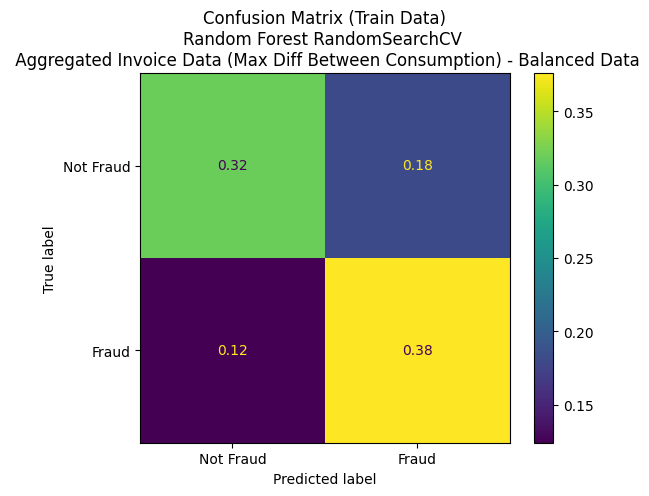

2025-05-13_031651
```
Model performance for
 Random Forest RandomSearchCV - Aggregated Invoice Data (Max Diff Between Consumption) - Balanced Data:
---------------
* Test Data F1 Score:  0.1936
* Test Data ROC AUC:   0.6817
* Test Data MCC:       0.1762
* Test Data Accuracy:  0.6427
* Test Data Precision: 0.1117
```


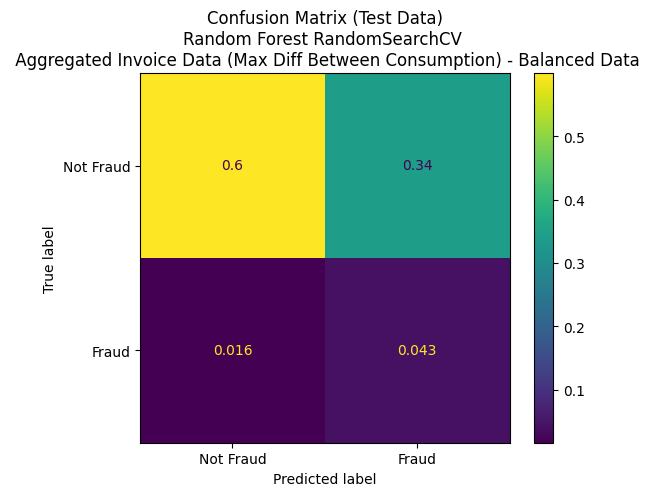

In [ ]:
import metrics_plot_functions as mep

mep.print_metric_stats(
    title= f"{model_name} - {model_details}",
    train_or_test="Train Data",
    actual_vals=y_train_resampled,
    predicted_vals=y_train_pred,
    )

mep.output_confusion_matrix(
    train_or_test="Train Data",
    actual_vals=y_train_resampled,
    predicted_vals=y_train_pred,
    display_labels=["Not Fraud", "Fraud"],
    title=f"{model_name} \n {model_details}",
)

print("========================")
print(timestamp_for_filename)

mep.print_metric_stats(
    title= f"{model_name} - {model_details}",
    train_or_test="Test Data",
    actual_vals=y_test,
    predicted_vals=y_test_pred)

mep.output_confusion_matrix(
    train_or_test="Test Data",
    actual_vals=y_test,
    predicted_vals=y_test_pred,
    display_labels=["Not Fraud", "Fraud"],
    title=f"{model_name} \n {model_details}",
)

In [ ]:
best_model.get_params